In [31]:
import pandas as pd
import numpy as np
import os
import sys

# Make `src` dir can be imported
project_root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))  # /aicup-predict-energy-generation
sys.path.append(project_root_path)

from src.utils import choose_device
from src.feature_engineering import create_time_features, create_sinusoidal_transformation_by_number, create_sinusoidal_transformation_year_month_day, calculate_pressure_diff

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit


import xgboost as xgb

In [32]:
df_raw_data = pd.read_csv('../data/processed_data/combined_data.csv')
df_raw_data['datetime'] = pd.to_datetime(df_raw_data['datetime'])
# make sure the sorting is correct
df_raw_data = df_raw_data.sort_values(by=['device','datetime']).reset_index(drop=True)

In [33]:
# parameterize the device for testing conveniently
df_device = choose_device(df_raw_data, 'L8')

## Preprocessing

In [34]:
df_device

,locationcode,datetime,windspeed,pressure,temperature,humidity,sunlight,power,device
1084283,8,2024-01-06 06:21:19,0.0,1016.10,14.67,80.94,23.33,0.00,L8
1084284,8,2024-01-06 06:22:19,0.0,1016.10,14.65,80.95,25.83,0.00,L8
1084285,8,2024-01-06 06:23:19,0.0,1016.07,14.63,81.00,30.83,0.00,L8
1084286,8,2024-01-06 06:24:19,0.0,1016.02,14.61,81.02,35.00,0.00,L8
1084287,8,2024-01-06 06:25:19,0.0,1016.06,14.60,81.07,41.67,0.00,L8
...,...,...,...,...,...,...,...,...,...
1201277,8,2024-08-31 15:07:16,0.0,1002.31,40.37,38.86,12590.83,32.83,L8
1201278,8,2024-08-31 15:08:16,0.0,1002.33,40.13,39.45,13351.67,40.63,L8
1201279,8,2024-08-31 15:09:16,0.0,1002.36,39.96,40.12,13168.33,38.16,L8
1201280,8,2024-08-31 15:10:16,0.0,1002.36,39.57,40.80,13605.83,43.10,L8


In [35]:
columns_to_standardize = ['windspeed', 'temperature', 'humidity', 'sunlight']


scaler  = StandardScaler()
df_standardized = df_device.copy()
df_standardized[columns_to_standardize] = scaler.fit_transform(df_standardized[columns_to_standardize])

## Feature engineering

In [36]:
df_fe_result = calculate_pressure_diff(df_standardized, column='pressure')
df_fe_result

,locationcode,datetime,windspeed,pressure,temperature,humidity,sunlight,power,device,pressure_diff
1084283,8,2024-01-06 06:21:19,-0.359678,1016.10,-1.787445,0.229870,-0.547503,0.00,L8,6.36
1084284,8,2024-01-06 06:22:19,-0.359678,1016.10,-1.790297,0.230381,-0.547392,0.00,L8,6.36
1084285,8,2024-01-06 06:23:19,-0.359678,1016.07,-1.793148,0.232938,-0.547171,0.00,L8,6.33
1084286,8,2024-01-06 06:24:19,-0.359678,1016.02,-1.796000,0.233961,-0.546986,0.00,L8,6.28
1084287,8,2024-01-06 06:25:19,-0.359678,1016.06,-1.797426,0.236517,-0.546690,0.00,L8,6.32
...,...,...,...,...,...,...,...,...,...,...
1201277,8,2024-08-31 15:07:16,-0.359678,1002.31,1.876697,-1.921849,0.009739,32.83,L8,-7.43
1201278,8,2024-08-31 15:08:16,-0.359678,1002.33,1.842480,-1.891680,0.043475,40.63,L8,-7.41
1201279,8,2024-08-31 15:09:16,-0.359678,1002.36,1.818242,-1.857420,0.035346,38.16,L8,-7.38
1201280,8,2024-08-31 15:10:16,-0.359678,1002.36,1.762638,-1.822649,0.054744,43.10,L8,-7.38


create sinusodial month mapping

In [37]:
month_numbers = list(range(1, 13))

# Create DataFrame
df_months = pd.DataFrame(month_numbers, columns=["month"])
df_months = create_sinusoidal_transformation_by_number(df_months, 'month', 12)
df_months

,month,month_sin,month_cos
0,1,5.000000e-01,8.660254e-01
1,2,8.660254e-01,5.000000e-01
2,3,1.000000e+00,6.123234e-17
3,4,8.660254e-01,-5.000000e-01
4,5,5.000000e-01,-8.660254e-01
5,6,1.224647e-16,-1.000000e+00
6,7,-5.000000e-01,-8.660254e-01
7,8,-8.660254e-01,-5.000000e-01
8,9,-1.000000e+00,-1.836970e-16
9,10,-8.660254e-01,5.000000e-01


#### General time frame

In [38]:
# Generate date range from 2023-01-01 to 2025-12-31
general_dates = pd.date_range(start="2023-01-01", end="2025-12-31")

# Create DataFrame and extract year, month, and day into separate columns
df_general_dates = pd.DataFrame({
    "year": general_dates.year,
    "month": general_dates.month,
    "day": general_dates.day
})
df_general_dates = create_sinusoidal_transformation_year_month_day(df_general_dates, 'general_ymd', 'year', 'month', 'day', 12)
df_general_dates

,year,month,day,general_ymd_sin,general_ymd_cos
0,2023,1,1,-5.000000e-01,-8.660254e-01
1,2023,1,2,8.660254e-01,5.000000e-01
2,2023,1,3,-1.000000e+00,-1.611765e-13
3,2023,1,4,8.660254e-01,-5.000000e-01
4,2023,1,5,-5.000000e-01,8.660254e-01
...,...,...,...,...,...
1091,2025,12,27,-6.359136e-11,1.000000e+00
1092,2025,12,28,-4.654404e-11,1.000000e+00
1093,2025,12,29,-8.770438e-11,1.000000e+00
1094,2025,12,30,-7.065706e-11,1.000000e+00


#### Aligns with a specific lunar calendar period

In [39]:
# Generate date range from 2023-01-01 to 2025-12-31
luner_dates = pd.date_range(start="2023-02-04", end="2025-02-03")

# Create DataFrame and extract year, month, and day into separate columns
df_luner_dates = pd.DataFrame({
    "year": luner_dates.year,
    "month": luner_dates.month,
    "day": luner_dates.day
})
df_luner_dates = create_sinusoidal_transformation_year_month_day(df_luner_dates, 'lunar_ymd', 'year', 'month', 'day', 12)
df_luner_dates

,year,month,day,lunar_ymd_sin,lunar_ymd_cos
0,2023,2,4,-8.660254e-01,-5.000000e-01
1,2023,2,5,-8.660254e-01,5.000000e-01
2,2023,2,6,-6.447061e-13,1.000000e+00
3,2023,2,7,8.660254e-01,5.000000e-01
4,2023,2,8,8.660254e-01,-5.000000e-01
...,...,...,...,...,...
726,2025,1,30,1.037450e-12,-1.000000e+00
727,2025,1,31,1.000000e+00,6.892798e-12
728,2025,2,1,3.420118e-13,-1.000000e+00
729,2025,2,2,-6.840235e-13,1.000000e+00


In [40]:
df_fe_result = create_time_features(df_fe_result, 'datetime')
df_fe_result.head()

,locationcode,datetime,windspeed,pressure,temperature,humidity,sunlight,power,device,pressure_diff,date,year,month,day,hour,min,day_of_week,week_of_year,quarter
1084283,8,2024-01-06 06:21:19,-0.359678,1016.10,-1.787445,0.229870,-0.547503,0.0,L8,6.36,2024-01-06,2024,1,6,6,21,5,1,1
1084284,8,2024-01-06 06:22:19,-0.359678,1016.10,-1.790297,0.230381,-0.547392,0.0,L8,6.36,2024-01-06,2024,1,6,6,22,5,1,1
1084285,8,2024-01-06 06:23:19,-0.359678,1016.07,-1.793148,0.232938,-0.547171,0.0,L8,6.33,2024-01-06,2024,1,6,6,23,5,1,1
1084286,8,2024-01-06 06:24:19,-0.359678,1016.02,-1.796000,0.233961,-0.546986,0.0,L8,6.28,2024-01-06,2024,1,6,6,24,5,1,1
1084287,8,2024-01-06 06:25:19,-0.359678,1016.06,-1.797426,0.236517,-0.546690,0.0,L8,6.32,2024-01-06,2024,1,6,6,25,5,1,1


In [41]:
df_fe_result_sinusoidal_time = pd.merge(df_fe_result, df_general_dates, how='left',  on=['year', 'month', 'day'])

In [42]:
# input data
drop_cols = ['locationcode', 'year', 'pressure']
df_fe_result_sinusoidal_time = df_fe_result_sinusoidal_time.drop(drop_cols, axis=1)
df_fe_result_sinusoidal_time

,datetime,windspeed,temperature,humidity,sunlight,power,device,pressure_diff,date,month,day,hour,min,day_of_week,week_of_year,quarter,general_ymd_sin,general_ymd_cos
0,2024-01-06 06:21:19,-0.359678,-1.787445,0.229870,-0.547503,0.00,L8,6.36,2024-01-06,1,6,6,21,5,1,1,7.926873e-15,1.0
1,2024-01-06 06:22:19,-0.359678,-1.790297,0.230381,-0.547392,0.00,L8,6.36,2024-01-06,1,6,6,22,5,1,1,7.926873e-15,1.0
2,2024-01-06 06:23:19,-0.359678,-1.793148,0.232938,-0.547171,0.00,L8,6.33,2024-01-06,1,6,6,23,5,1,1,7.926873e-15,1.0
3,2024-01-06 06:24:19,-0.359678,-1.796000,0.233961,-0.546986,0.00,L8,6.28,2024-01-06,1,6,6,24,5,1,1,7.926873e-15,1.0
4,2024-01-06 06:25:19,-0.359678,-1.797426,0.236517,-0.546690,0.00,L8,6.32,2024-01-06,1,6,6,25,5,1,1,7.926873e-15,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116994,2024-08-31 15:07:16,-0.359678,1.876697,-1.921849,0.009739,32.83,L8,-7.43,2024-08-31,8,31,15,7,5,35,3,8.660254e-01,-0.5
116995,2024-08-31 15:08:16,-0.359678,1.842480,-1.891680,0.043475,40.63,L8,-7.41,2024-08-31,8,31,15,8,5,35,3,8.660254e-01,-0.5
116996,2024-08-31 15:09:16,-0.359678,1.818242,-1.857420,0.035346,38.16,L8,-7.38,2024-08-31,8,31,15,9,5,35,3,8.660254e-01,-0.5
116997,2024-08-31 15:10:16,-0.359678,1.762638,-1.822649,0.054744,43.10,L8,-7.38,2024-08-31,8,31,15,10,5,35,3,8.660254e-01,-0.5


## Check before splitting

In [43]:
df_fe_result_sinusoidal_time.describe()

,datetime,windspeed,temperature,humidity,sunlight,power,pressure_diff,month,day,hour,min,day_of_week,week_of_year,quarter,general_ymd_sin,general_ymd_cos
count,116999,1.169990e+05,1.169990e+05,1.169990e+05,1.169990e+05,116999.000000,116999.000000,116999.000000,116999.000000,116999.000000,116999.000000,116999.000000,116999.0,116999.000000,1.169990e+05,116999.000000
mean,2024-04-23 21:36:28.322771712,1.399235e-16,-2.720734e-16,4.654398e-16,4.275439e-17,126.108926,0.002692,4.263660,15.371884,11.237429,29.544398,3.034265,16.768143,1.748818,-3.641779e-03,0.279173
min,2024-01-06 06:21:19,-3.596783e-01,-2.055484e+00,-3.324454e+00,-5.476509e-01,0.000000,-14.920000,1.000000,1.000000,4.000000,0.000000,0.000000,1.0,1.000000,-8.660254e-01,-0.500000
25%,2024-02-24 09:49:35,-3.596783e-01,-8.079645e-01,-5.892968e-01,-4.624073e-01,0.750000,-5.210000,2.000000,8.000000,8.000000,15.000000,1.000000,8.0,1.000000,-7.987280e-12,-0.500000
50%,2024-05-01 18:13:45,-3.596783e-01,1.896262e-02,9.743282e-02,-3.312351e-01,5.540000,-1.090000,5.000000,15.000000,11.000000,30.000000,3.000000,18.0,2.000000,4.824914e-13,1.000000
75%,2024-06-16 06:49:33,-3.596783e-01,6.605440e-01,8.741582e-01,-7.400761e-02,26.210000,5.620000,6.000000,22.000000,15.000000,44.000000,5.000000,24.0,2.000000,1.751028e-11,1.000000
max,2024-08-31 15:11:16,1.716574e+01,3.862748e+00,1.204484e+00,4.672857e+00,2620.130000,16.360000,8.000000,31.000000,19.000000,59.000000,6.000000,35.0,3.000000,8.660254e-01,1.000000
std,NaN,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,391.083753,6.649853,2.218328,8.576396,3.803584,17.250370,2.041543,9.555967,0.760260,6.003359e-01,0.749436


In [44]:
df_fe_result_sinusoidal_time = df_fe_result_sinusoidal_time.set_index('datetime')

In [45]:
df_fe_result_sinusoidal_time.head()

,windspeed,temperature,humidity,sunlight,power,device,pressure_diff,date,month,day,hour,min,day_of_week,week_of_year,quarter,general_ymd_sin,general_ymd_cos
datetime,,,,,,,,,,,,,,,,,
2024-01-06 06:21:19,-0.359678,-1.787445,0.229870,-0.547503,0.0,L8,6.36,2024-01-06,1,6,6,21,5,1,1,7.926873e-15,1.0
2024-01-06 06:22:19,-0.359678,-1.790297,0.230381,-0.547392,0.0,L8,6.36,2024-01-06,1,6,6,22,5,1,1,7.926873e-15,1.0
2024-01-06 06:23:19,-0.359678,-1.793148,0.232938,-0.547171,0.0,L8,6.33,2024-01-06,1,6,6,23,5,1,1,7.926873e-15,1.0
2024-01-06 06:24:19,-0.359678,-1.796000,0.233961,-0.546986,0.0,L8,6.28,2024-01-06,1,6,6,24,5,1,1,7.926873e-15,1.0
2024-01-06 06:25:19,-0.359678,-1.797426,0.236517,-0.546690,0.0,L8,6.32,2024-01-06,1,6,6,25,5,1,1,7.926873e-15,1.0


In [56]:
df_fe_result_sinusoidal_time.date.value_counts()

date
2024-07-04    839
2024-06-16    838
2024-07-07    837
2024-06-09    837
2024-06-15    836
             ... 
2024-08-26    145
2024-06-20     70
2024-08-22     54
2024-05-14     35
2024-06-11     21
Name: count, Length: 194, dtype: int64

In [57]:
df_fe_result_sinusoidal_time[(df_fe_result_sinusoidal_time['month'] == 6) & (df_fe_result_sinusoidal_time['day'] == 11)]

,windspeed,temperature,humidity,sunlight,power,device,pressure_diff,date,month,day,hour,min,day_of_week,week_of_year,quarter,general_ymd_sin,general_ymd_cos
datetime,,,,,,,,,,,,,,,,,
2024-06-11 18:32:14,-0.359678,0.282724,1.204484,-0.538450,0.01,L8,-8.61,2024-06-11,6,11,18,32,1,24,2,4.634669e-12,1.0
2024-06-11 18:33:13,-0.359678,0.321219,1.204484,-0.539522,0.01,L8,-8.68,2024-06-11,6,11,18,33,1,24,2,4.634669e-12,1.0
2024-06-11 18:34:13,-0.359678,0.342605,1.204484,-0.540446,0.01,L8,-8.66,2024-06-11,6,11,18,34,1,24,2,4.634669e-12,1.0
2024-06-11 18:35:14,-0.359678,0.356862,1.204484,-0.541258,0.01,L8,-8.66,2024-06-11,6,11,18,35,1,24,2,4.634669e-12,1.0
2024-06-11 18:36:14,-0.359678,0.363991,1.204484,-0.541961,0.00,L8,-8.63,2024-06-11,6,11,18,36,1,24,2,4.634669e-12,1.0
2024-06-11 18:37:14,-0.359678,0.371120,1.204484,-0.542552,0.00,L8,-8.63,2024-06-11,6,11,18,37,1,24,2,4.634669e-12,1.0
2024-06-11 18:38:14,-0.359678,0.378248,1.204484,-0.543106,0.00,L8,-8.61,2024-06-11,6,11,18,38,1,24,2,4.634669e-12,1.0
2024-06-11 18:39:14,-0.359678,0.385377,1.204484,-0.543660,0.00,L8,-8.59,2024-06-11,6,11,18,39,1,24,2,4.634669e-12,1.0
2024-06-11 18:40:13,-0.359678,0.382525,1.204484,-0.544215,0.00,L8,-8.64,2024-06-11,6,11,18,40,1,24,2,4.634669e-12,1.0


## Train/Test split

In [ ]:
def get_test_size(days):
    # since the data is one minute one row
    return days*24*60

In [68]:
day_gap = 24*60

In [69]:
tss = TimeSeriesSplit(n_splits=5, test_size=get_test_size(5), gap = day_gap)

In [79]:
def split_train_test(df, plot=False):
    fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)

    fold = 0
    for train_idx, val_idx in tss.split(df):
        df_train = df.iloc[train_idx]
        df_test = df.iloc[val_idx]

        if plot:

            df_train['power'].plot(ax=axs[fold],
                                label='Training Set',
                                title = f'Data Train/Test Split Fold {fold}')
            df_test['power'].plot(ax=axs[fold], label='Test Set')
            axs[fold].axvline(df_test.index.min(), color='black', ls='--')

            fold += 1

    return df_train, df_test

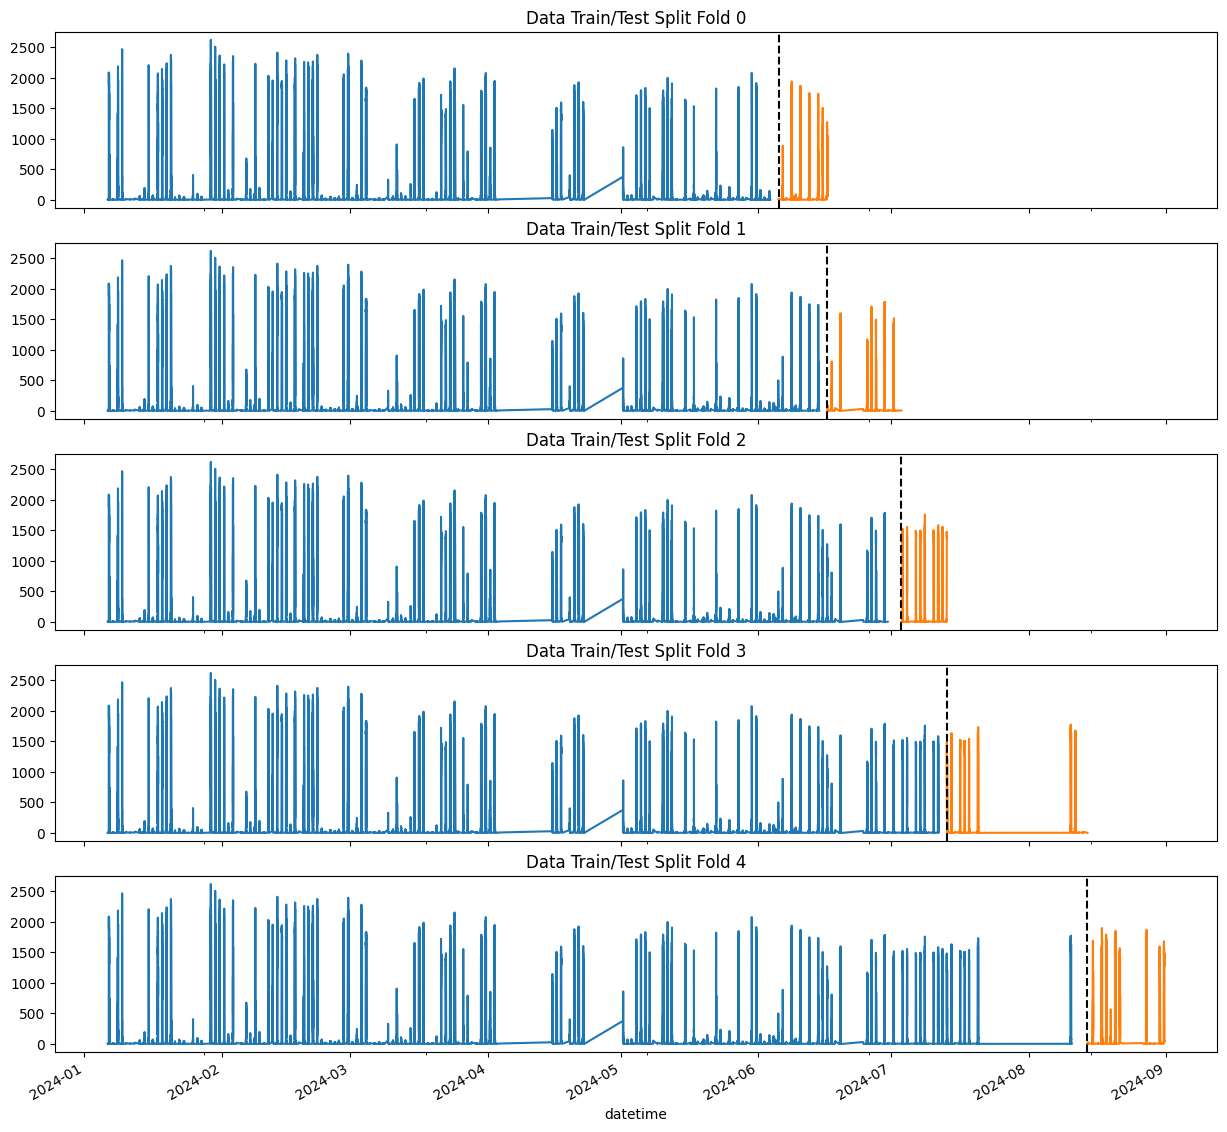

In [81]:
df_train, df_test = split_train_test(df=df_fe_result_sinusoidal_time, plot=True)

## Train Using Cross Validation

In [ ]:
def time_based_train_test_split(df, date_column='date', cutoff_date=None, split_ratio=0.7):
    """
    Split a DataFrame into train and test sets based on a time-based cutoff.

    Parameters:
    - df(pd.DataFrame): The dataframe to split.
    - date_column(str|datetime): The column name containing date information.
    - cutoff_date(str|datetime|None): A specific date for splitting(format: YYYY-MM-DD).
        IF None, the function will use the split_ratio to determine the split point.
    - split_ratio(float): The proportion of data to include in the train set (if cutoff_date is None).

    Returns:
    - df_train (pd.DataFrame): Training set DataFrame.
    - df_test (pd.DataFrame): Testing set DataFrame.(Actually it is validation set)
    """

    # Ensure the data column format is correct
    df[date_column] = pd.to_datetime(df[date_column])

    df = df.sort_values(by=date_column)

    if cutoff_date is not None:
        cutoff_date = pd.to_datetime(cutoff_date)
    else:
        cutoff_date = df[date_column].quantile(split_ratio)

    df_train = df[df[date_column] <= cutoff_date]
    df_test = df[df[date_column] > cutoff_date]

    return df_train, df_test

In [ ]:
df_train, df_test = time_based_train_test_split(df_fe_result_sinusoidal_time, 'date', None, 0.7)

In [ ]:
df_train.shape

(82129, 18)

In [ ]:
df_test.shape

(34870, 18)